# Numerical Results for the A+B→C Network

### Compare Gillespie simulation with mass action kinetics and Plefka approximation

In [27]:
using Pkg
cd(@__DIR__)
Pkg.activate("../../")
using CRN

include("plotting.jl")

 Activating environment at `~/ownCloud/Master/Simulations/CRN/Project.toml`


plot_hatTheta (generic function with 1 method)

In [7]:
# Parameters
num_species = 3     # number of species
num_int = 1         # number of interaction reaction

# Reaction constants
k1 = [8, 8, 3]      # Creation
k2 = [3, 2, 1.5]    # Annihiliation
k3 = [0.5]          # Interaction
k = [k1, k2, k3]

# Stoichiometric
s_i = zeros(Int, num_int, num_species)
r_i = copy(s_i)
s_i[1,:] = [0 0 1]
r_i[1,:] = [1 1 0]

# Times
t_init = 0.0        # Start time
t_final = 5.0       # End time
delta_t = 0.01      # time step
tspan = collect(t_init:delta_t:t_final)

# Initial condition
x0 = k1 ./ k2

3-element Array{Float64,1}:
 2.6666666666666665
 4.0
 2.0

## Gillespie Simulation

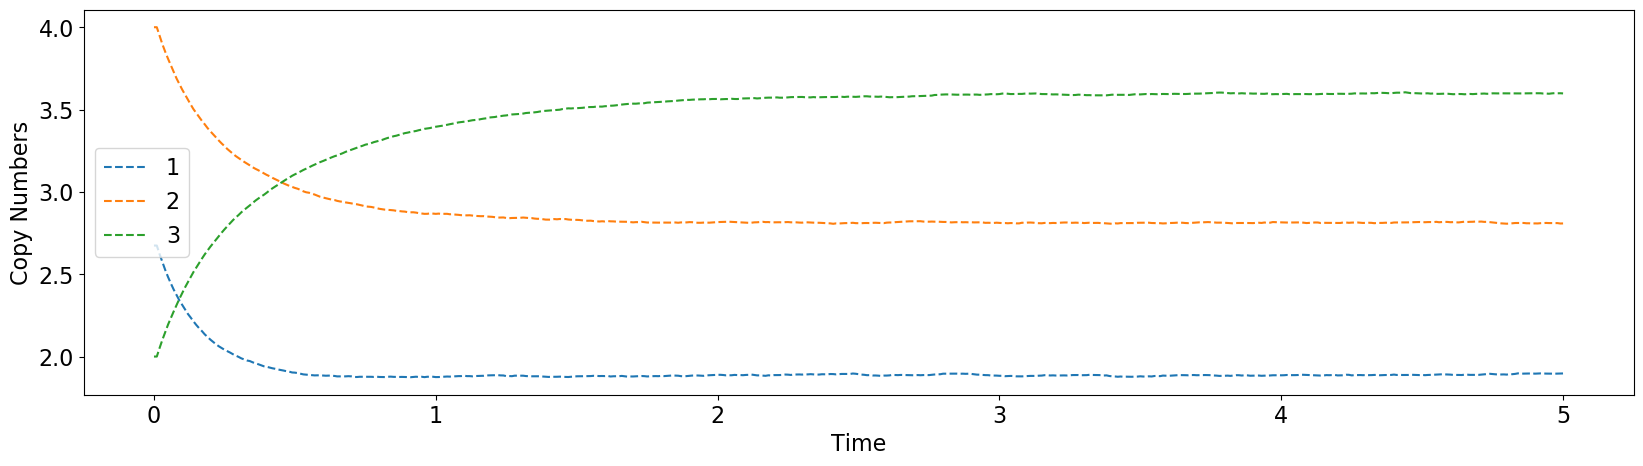

PyObject Text(32.999999999999986, 0.5, 'Copy Numbers')

In [8]:
N = 100000    # Repititions
res_gil = gillespie_avg(x0, k, s_i, r_i, tspan, N)
plot_trajectories(res_gil)

## Mass Action Kinetics

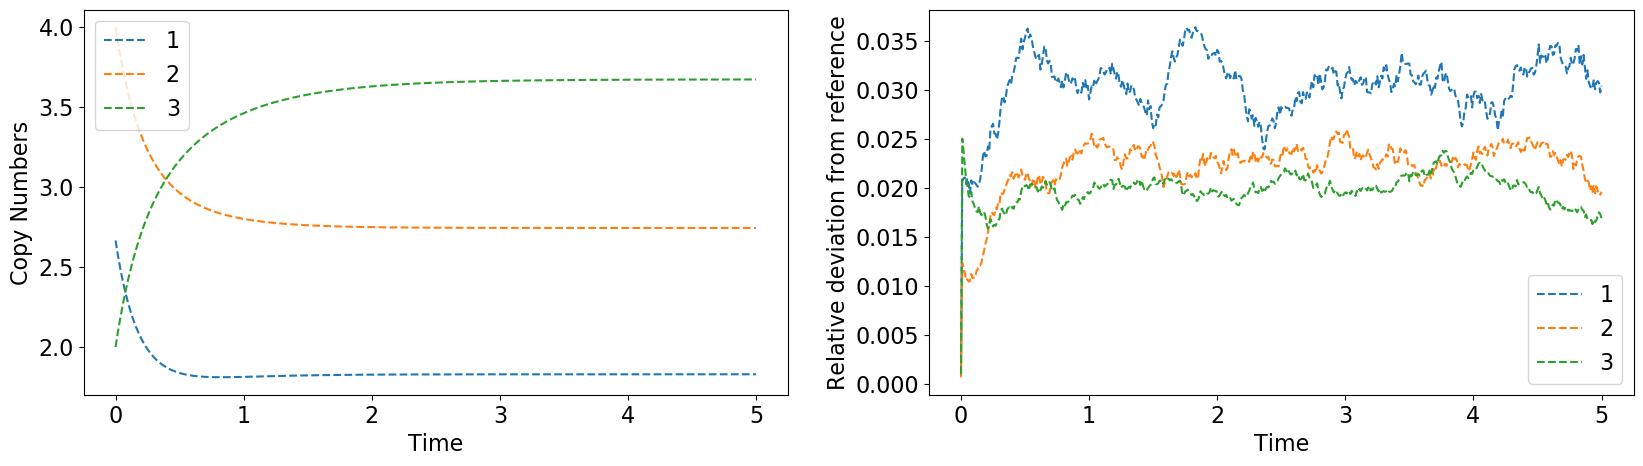

PyObject Text(850.2045454545454, 0.5, 'Relative deviation from reference')

In [4]:
function f_massAction!(du,u,k,t)
    du[1] = k1[1] - k2[1]*u[1] - k3[1]*u[1]*u[2]
    du[2] = k1[2] - k2[2]*u[2] - k3[1]*u[1]*u[2]
    du[3] = k1[3] - k2[3]*u[3] + k3[1]*u[1]*u[2]
end

ts = (tspan[1], tspan[end])
res_ma = ode_solver(f_massAction!, k, ts, x0)
plot_trajectories_and_deviation(res_ma, res_gil)

## Plefka with linear O.P. and power α¹ 

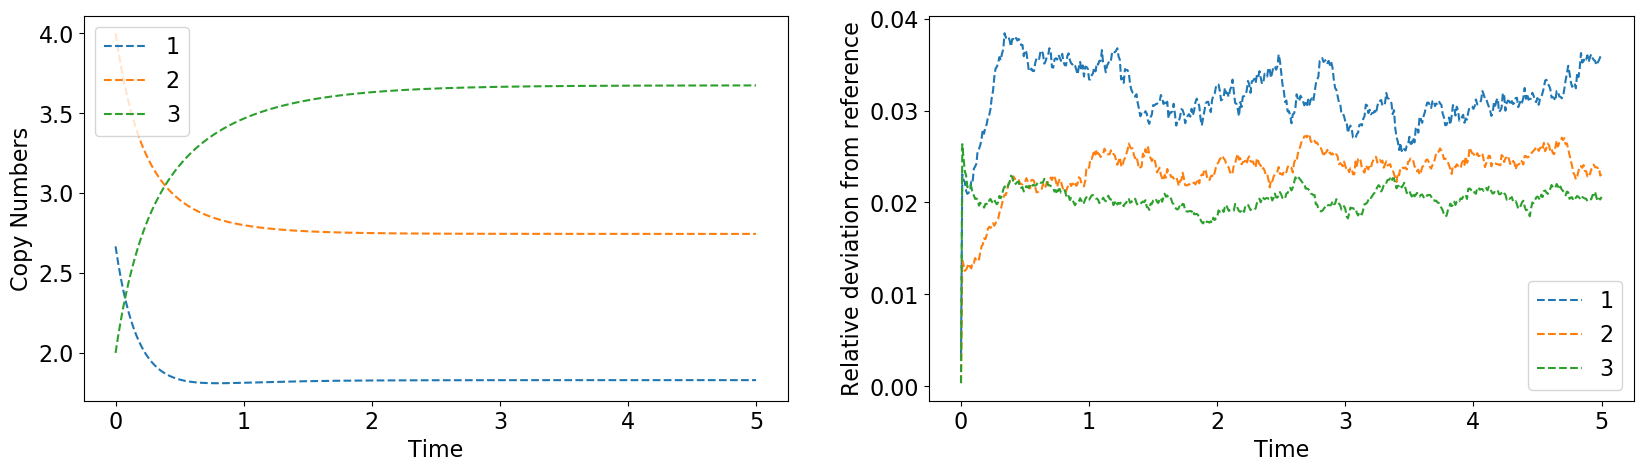

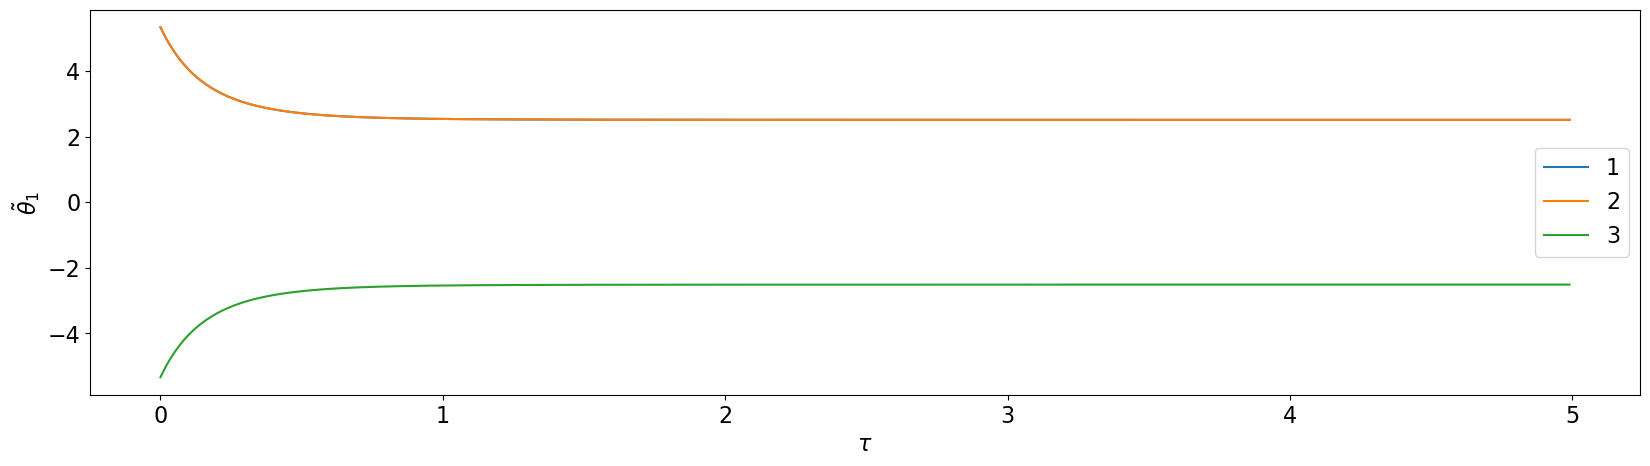

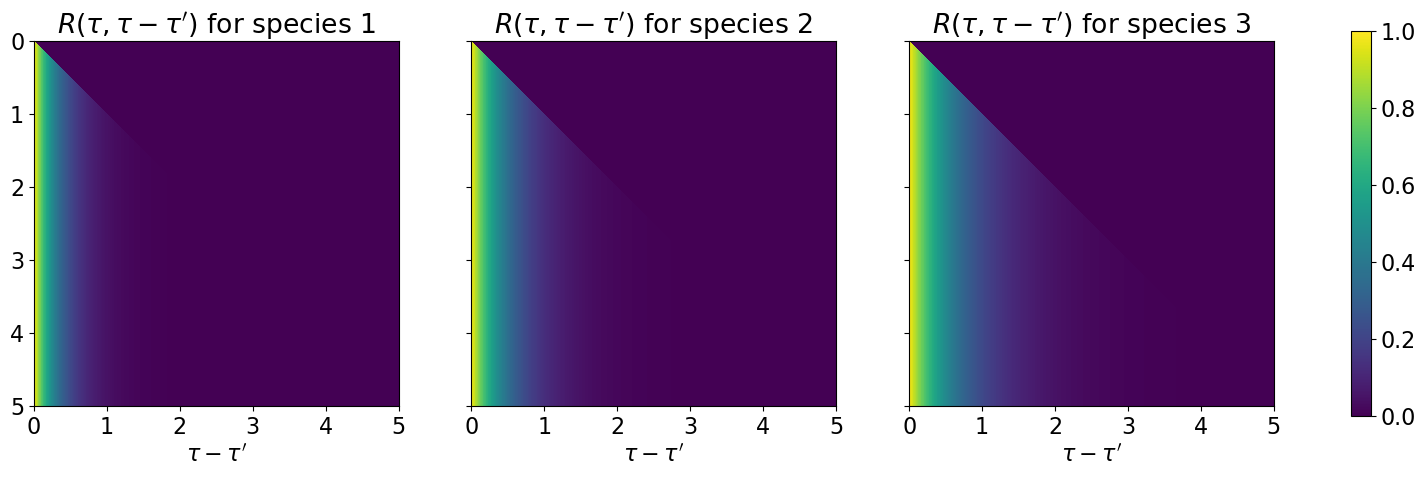

In [13]:
plf_sim_11 = Plefka(1.0, 1, "linear") # α, alphaOrder, orderParameter
res_plf_11 = euler_step(x0, k, tspan, plf_sim_11)
plot_trajectories_and_deviation(res_plf_11[1], res_gil)
plot_hatTheta(plf_sim_11, res_plf_11[3])
plot_responses(res_plf_11[2])

## Plefka with linear O.P. and power α²

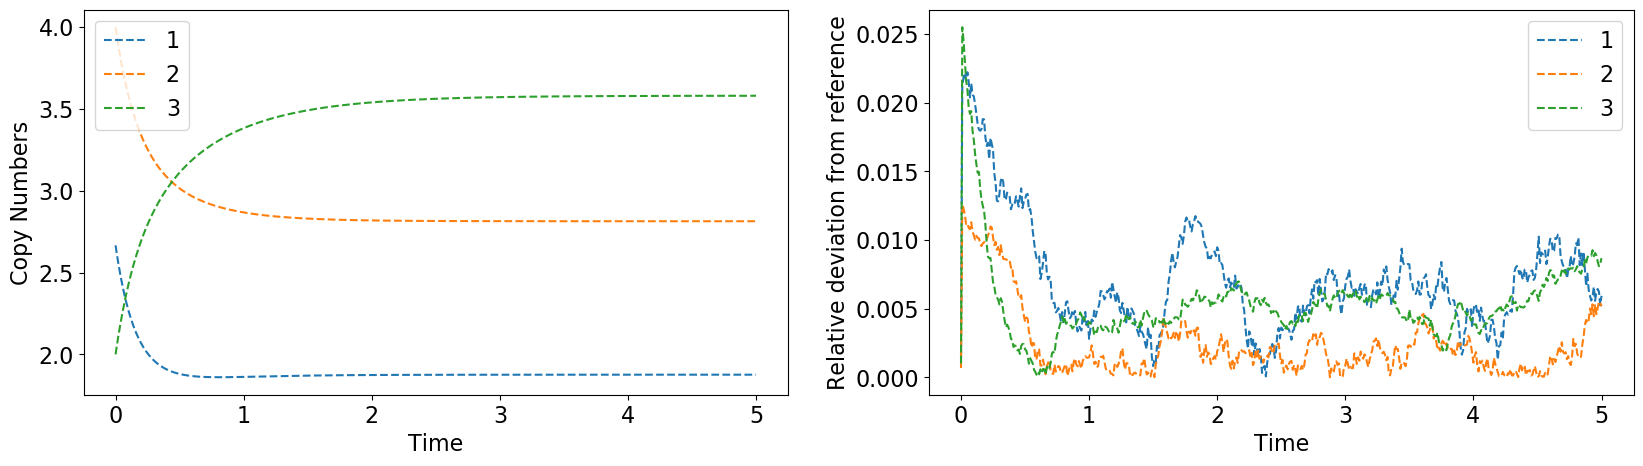

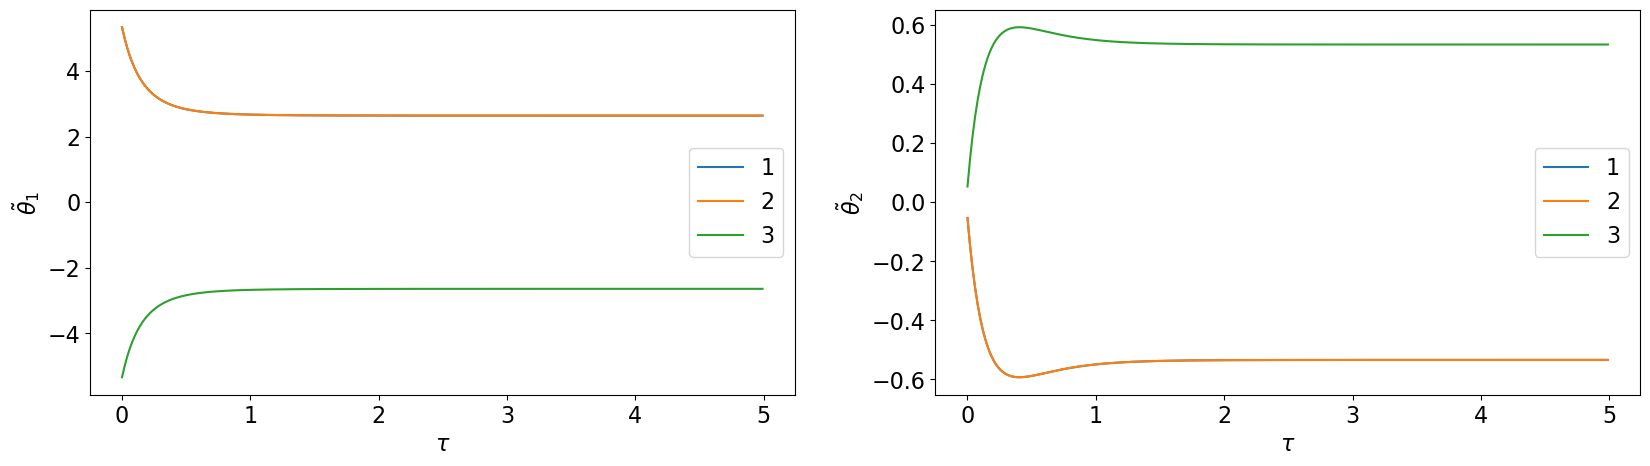

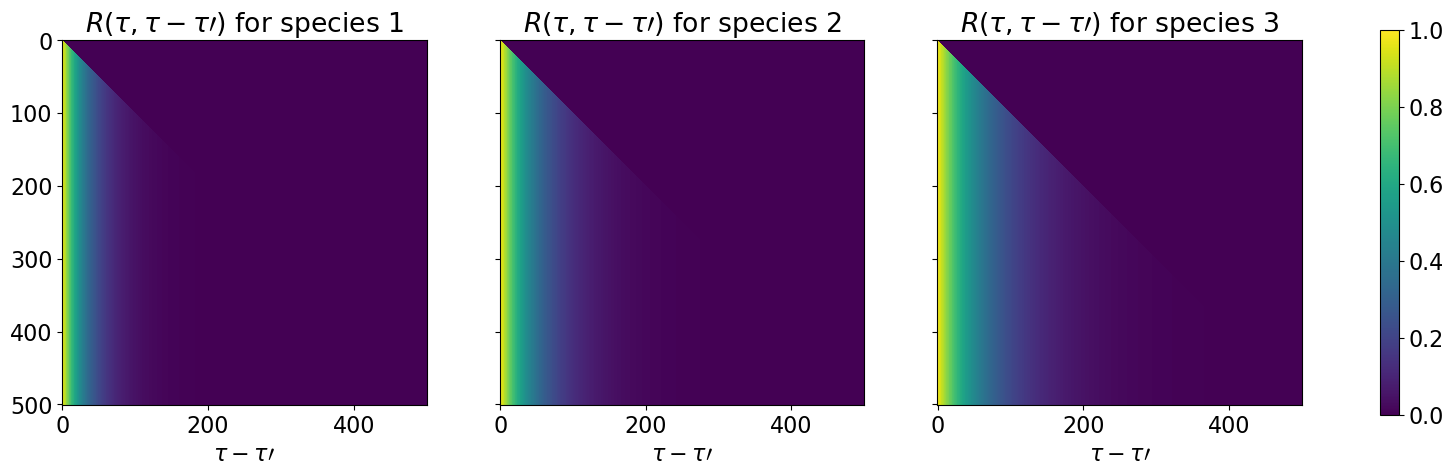

PyObject <matplotlib.colorbar.Colorbar object at 0x7faf3913cee0>

In [6]:
plf_sim_21 = Plefka(1.0, 2, "linear") # α, alphaOrder, orderParameter
res_plf_21 = euler_step(x0, k, tspan, plf_sim_21)
plot_trajectories_and_deviation(res_plf_21[1], res_gil)
plot_hatTheta(plf_sim_21, res_plf_21[3])
plot_responses(res_plf_21[2])

## Plefka with quad O.P. and power α¹ 

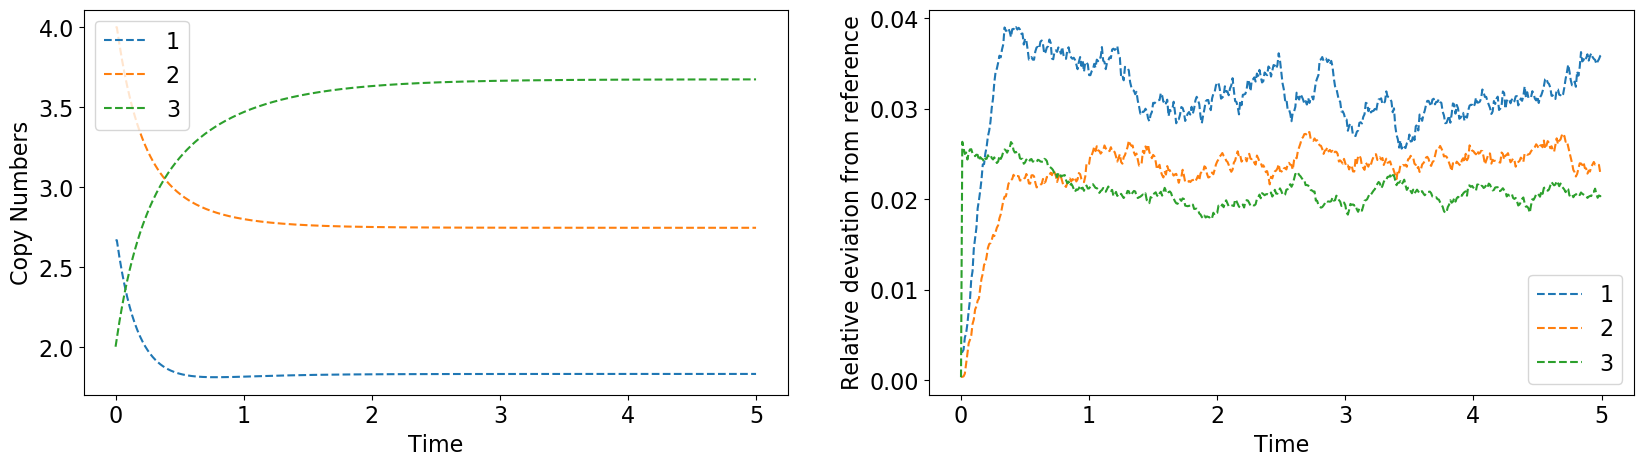

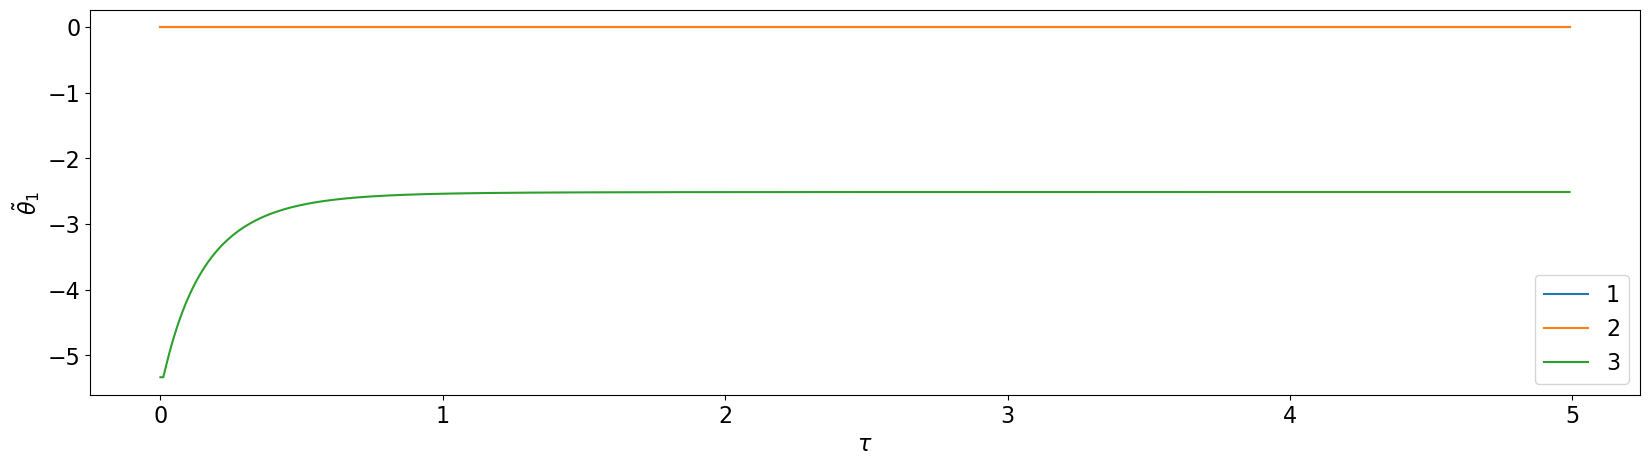

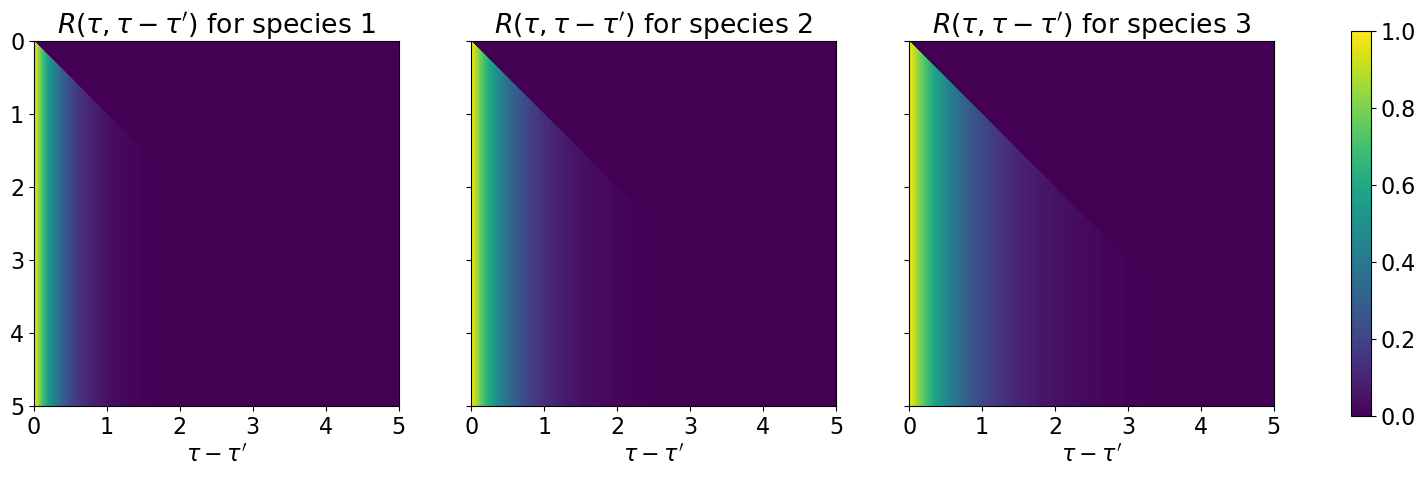

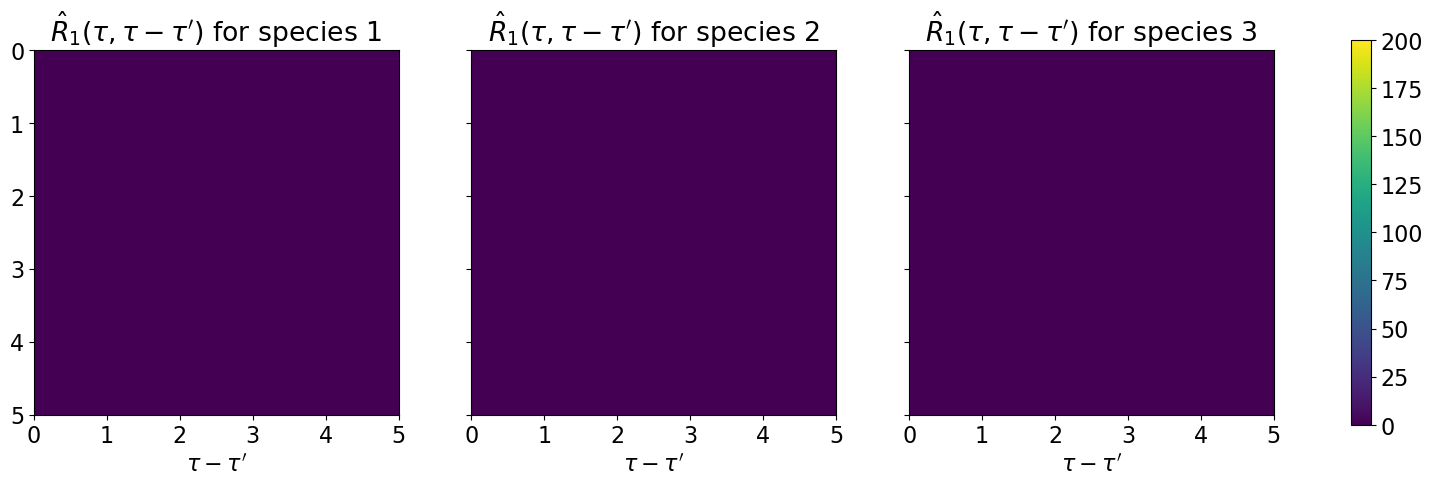

In [20]:
plf_sim_12 = Plefka(1.0, 1, "quad") # α, alphaOrder, orderParameter
res_plf_12 = euler_step(x0, k, tspan, plf_sim_12)
plot_trajectories_and_deviation(res_plf_12[1], res_gil)
plot_hatTheta(plf_sim_12, res_plf_12[3])
plot_responses(res_plf_12[2])
plot_hatR(plf_sim_12, tspan, res_plf_12[3].hatR1)

## Plefka with quad O.P. and power α²

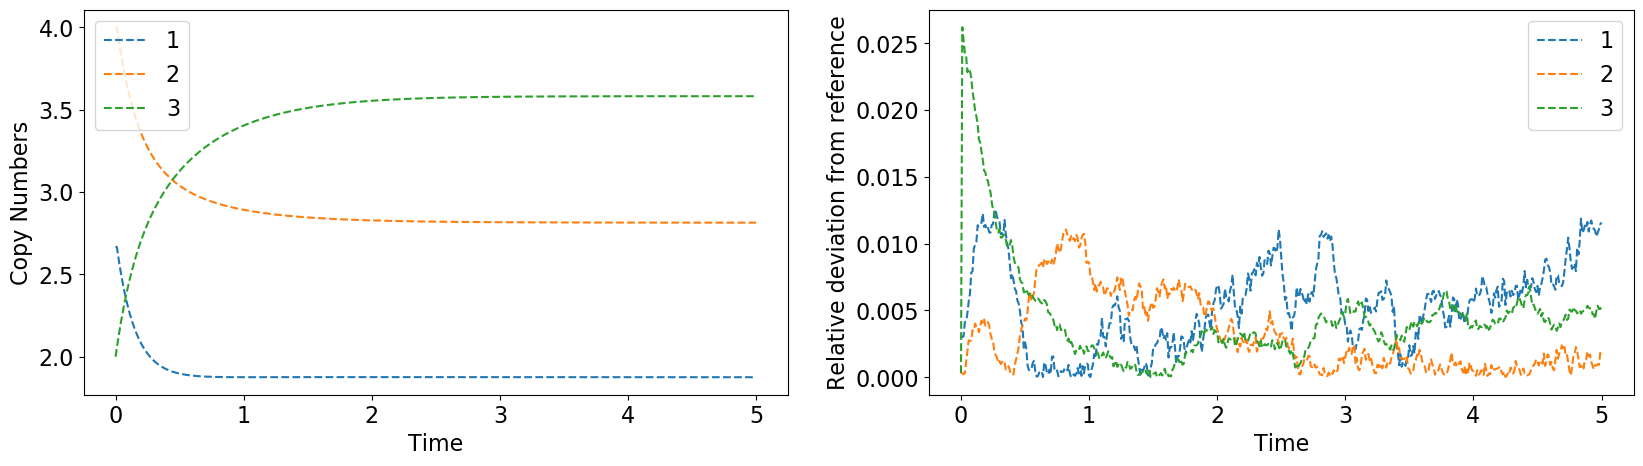

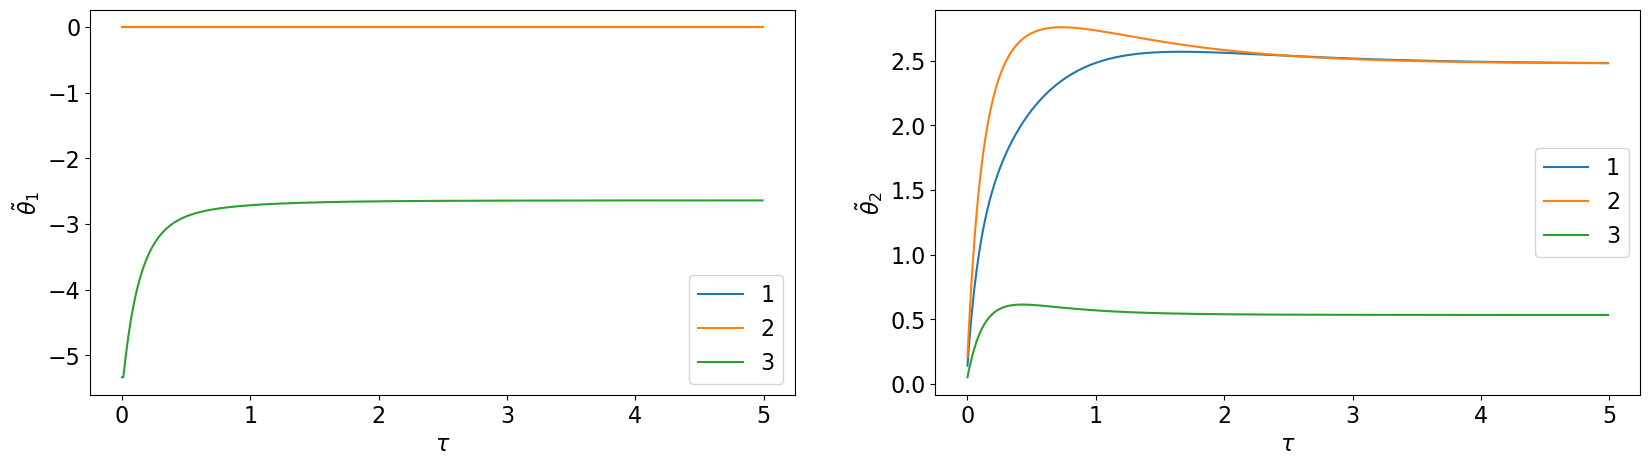

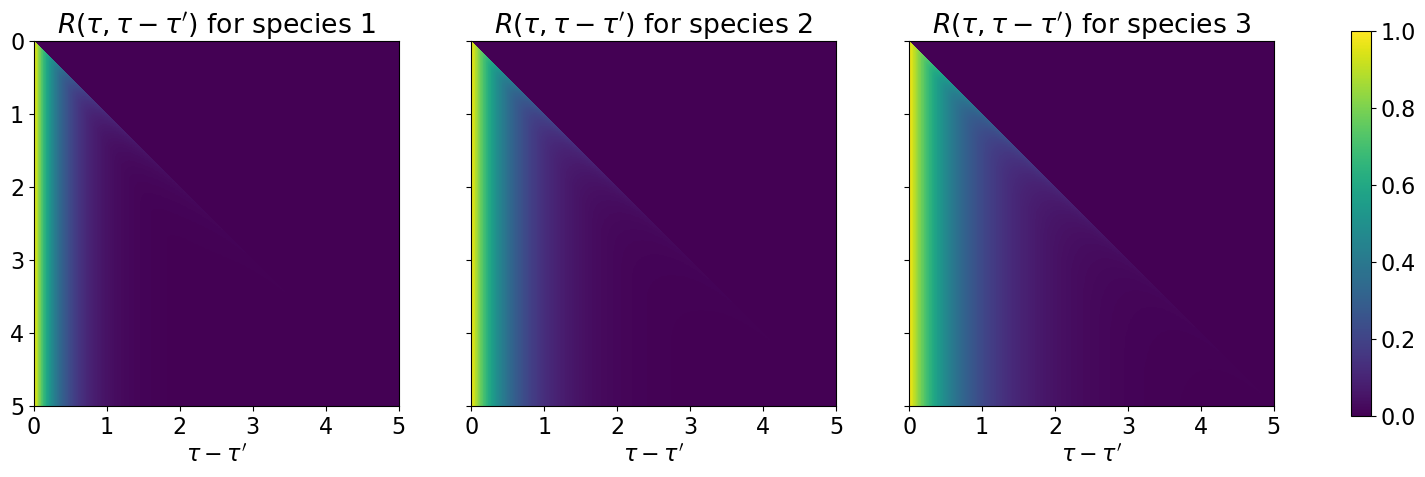

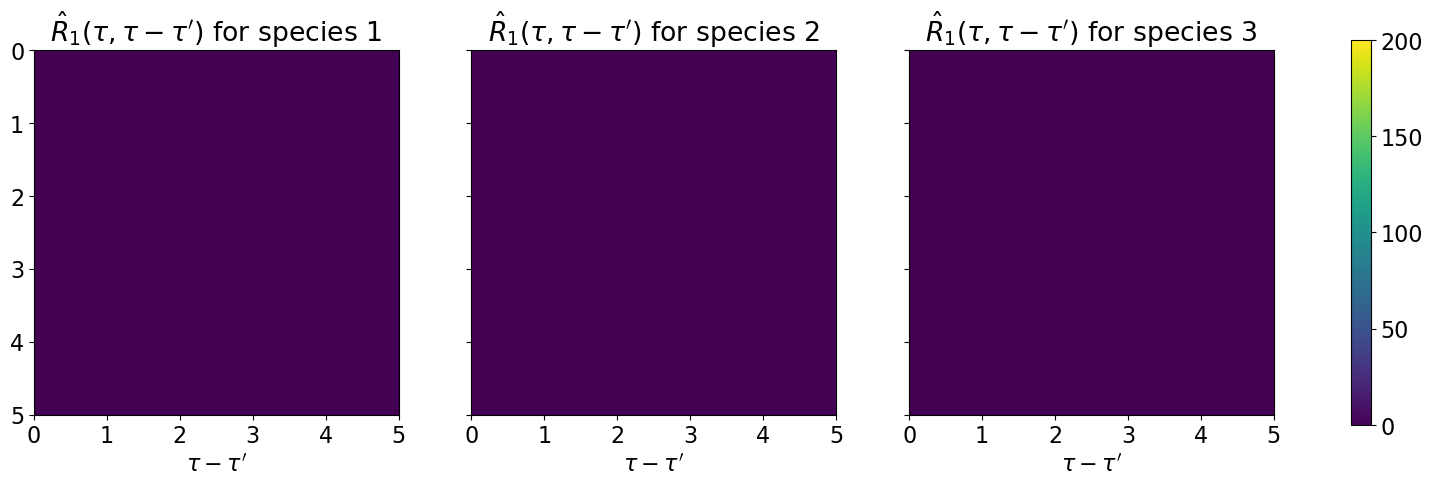

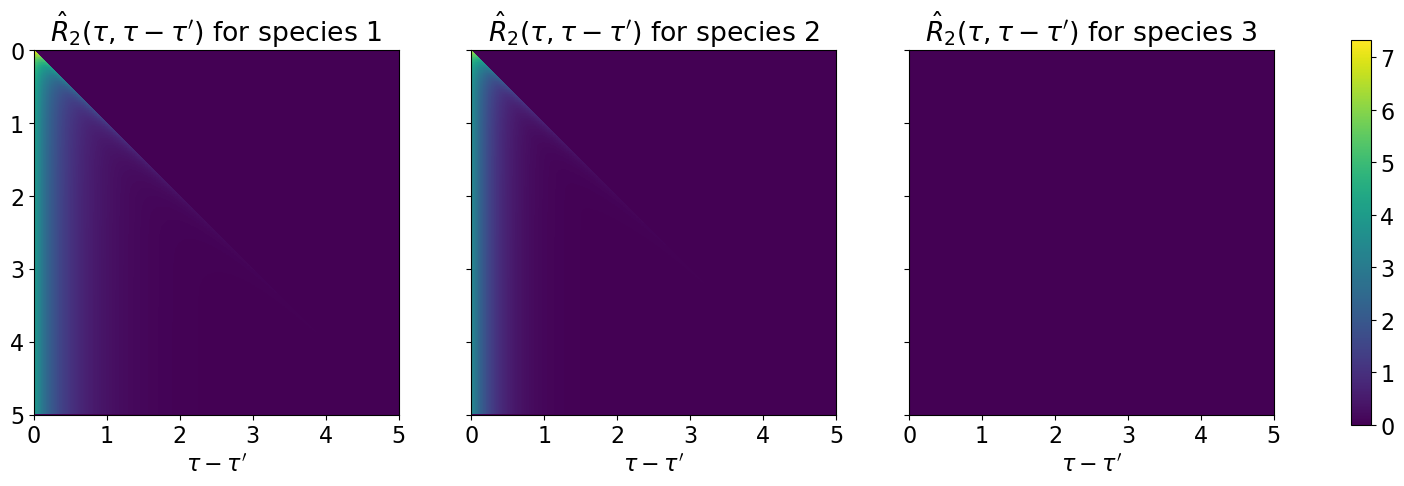

In [28]:
plf_sim_22 = Plefka(1.0, 2, "quad") # α, alphaOrder, orderParameter
res_plf_22 = euler_step(x0, k, tspan, plf_sim_22)
plot_trajectories_and_deviation(res_plf_22[1], res_gil)
plot_hatTheta(plf_sim_22, res_plf_22[3])
plot_responses(res_plf_22[2])
plot_hatR(plf_sim_22, tspan, res_plf_22[3].hatR1)
plot_hatR(plf_sim_22, tspan, -res_plf_22[3].hatR2, quadR=true)

In [25]:
# Comments:
# - (l.319) update hatR1 with y[:,self.i-1] for i=0 ???
# - (l.55) reaction prob vector with y[k,i]**r_i[m,k]
# - deviation first time step: large jump ???
# - ignore last time step for hatTheta ???

# TODOs
# - better arrangement of subplots